In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append("../")

import numpy as np
import cv2
import torch
import imageio
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

from codes.video_handling import videoObj

from detectron2.data.datasets.coco import load_coco_json
from detectron2.data import MetadataCatalog

from detectron2.config import get_cfg
from detectron2.data.datasets import register_coco_instances
from detectron2.data import build_detection_test_loader,get_detection_dataset_dicts
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.utils.video_visualizer import VideoVisualizer


from detectron2.structures.boxes import Boxes, BoxMode, pairwise_iou, matched_boxlist_iou
from codes.utils.register_datasets import register_mosquitoes
from codes.utils.img_utils import add_bboxes_on_image, phase_correlation


In [3]:
# register_coco_instances("mbg_test", 
#                         {},
#                         "../data/_under_construction/coco_format_Test.json",
#                         "../data/_under_construction/Test")

# MetadataCatalog.get("mbg_test").set(thing_classes=["tire"], thing_colors=[(255,0,0)])

# # dataset_dicts = load_coco_json("../data/_under_construction/coco_format_Test.json",
# #                                "../data/_under_construction/Test",
# #                                dataset_name="mbg_test", extra_annotation_keys=None)

# dataset_dicts = get_detection_dataset_dicts(["mbg_test"], filter_empty=True)

register_mosquitoes()

In [4]:
data_path = "../data/_under_construction"
video_name = "20181022_rectfied_DJI_0031.avi"
video_path = os.path.join(data_path, video_name)
output_path = "teste.avi"
quality = 5

In [5]:
class Video(object):
    
    def __init__(self, video_path):
        self.vid = cv2.VideoCapture(video_path)
        self.width = int(self.vid.get(cv2.CAP_PROP_FRAME_WIDTH))
        self.height = int(self.vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
        self.fps = self.vid.get(cv2.CAP_PROP_FPS)
        self.n_frames = int(self.vid.get(cv2.CAP_PROP_FRAME_COUNT))

    def frame_from_video(self):
        while self.vid.isOpened():
            success, frame = self.vid.read()
            if success:
                yield frame
            else:
                break

    def get_nth_frame(self, n):    
        self.vid.set(cv2.CAP_PROP_POS_FRAMES, n)
        success, frame = self.vid.read()
        if success:
            return frame
        print("empty frame")
        return frame

    def reset_vid(self):
        self.vid.set(cv2.CAP_PROP_POS_FRAMES, 0)
        
    def draw_preds(self, frame, preds):
        raise NotImplementedError()

In [6]:
def run_on_image(img, predictor):
    outputs = predictor(img)    
    v = Visualizer(img[:, :, ::-1],
               metadata=MetadataCatalog.get("mbg_test").set(thing_colors=[(255,0,0)]), 
               scale=1,
               instance_mode=ColorMode.SEGMENTATION)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    return v.get_image() 

In [7]:
model_name = "faster_rcnn_R_50_C4_1x"
fold = 0
set_ = 1

config_file = os.path.join("..",  "codes", "configs", "mosquitoes", model_name + ".yaml")
cfg = get_cfg()
cfg.merge_from_file(config_file)

cfg.MODEL.WEIGHTS = os.path.join("..", "output", model_name, f"mbg_fold{fold}_set_{set_}", "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

cfg.MODEL.RPN.PRE_NMS_TOPK_TRAIN = 600
cfg.MODEL.RPN.PRE_NMS_TOPK_TEST = 300
cfg.MODEL.RPN.POST_NMS_TOPK_TRAIN = 50
cfg.MODEL.RPN.POST_NMS_TOPK_TEST = 50

predictor = DefaultPredictor(cfg)

## Running on video

In [8]:
# video = Video(video_path)

# for frame in tqdm(frame_gen, total=video.n_frames):    
#     im = cv2.resize(frame, (1333, 800)) # resize as model was trained
#     res = run_on_image(im, predictor)
    
#     # resize to original size
#     res = cv2.resize(res, (video.width, video.height))
#     output_file.write(res[:, :, ::-1])

# output_file.release()

In [9]:
def run_on_video(video_path, predictor, output_path=None):
    
    video = Video(video_path)
    frame_gen = video.frame_from_video()
    
    detections = dict()
    
    if output_path is not None:
        
        output_file = cv2.VideoWriter(
            filename=output_path,
            # some installation of opencv may not support x264 (due to its license),
            # you can try other format (e.g. MPEG)
            fourcc=cv2.VideoWriter_fourcc(*"x264"),
            fps=video.fps,
            frameSize=(video.width, video.height),
            isColor=True,
        )    
        
    for idx, frame in enumerate(tqdm(frame_gen, total=video.n_frames)): 
        
#         im = cv2.resize(frame, (1333, 800)) # resize as model was trained
        res = predictor(frame)
        detections[f'frame_{idx:04d}'] = res        
    
        # resize to original size
#         res = cv2.resize(res, (video.width, video.height))

        if output_path is not None:
            output_file.write(res[:, :, ::-1])
    
    if output_path is not None:
        output_file.release()   
        
    return detections

In [10]:
# video through the model
list_of_videos = ["20181022_rectfied_DJI_0031.avi",                
                 ]

det = dict()
for vid in tqdm(list_of_videos):
    
    det[vid] = dict()
    
    output_path = model_name + "_" +vid
    
    det[vid] = run_on_video(
        os.path.join(data_path, vid),
        predictor    
    )
    

In [11]:
# data_path = "../data/_under_construction"
# video_name = "20181022_rectfied_DJI_0031.avi"
# video_path = os.path.join(data_path, video_name)

vid = videoObj(video_path,
              video_path.replace(".avi", ".txt"))
frame_gen = vid.frame_from_video()


In [12]:
frames_nb = []
nb_anno = []
nb_pred = []

for idx, frame in enumerate(tqdm(frame_gen, total=vid.videoInfo.getNumberOfFrames())): 
    
    anno = vid.get_frame_annotations(idx)    
    tires = [obj for obj in anno if "tire" in obj]    
    
    output = det[list_of_videos[0]][f'frame_{idx:04d}']
          
    frames_nb.append(idx)
    nb_anno.append(len(tires))
    nb_pred.append(len(output['instances']))
      

In [13]:
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=frames_nb, y=nb_anno,
                    mode='lines+markers',
                    name='gt'))
fig.add_trace(go.Scatter(x=frames_nb, y=nb_pred,
                    mode='lines+markers',
                    name='dt'))

fig.update_layout(
#     title="Plot Title",
    yaxis_title="# bboxes",
    xaxis_title="frame number",
#     font=dict(
#         family="Courier New, monospace",
#         size=18,
#         color="#7f7f7f"
#     )
)

fig.show()

In [14]:
def display_results_on_frame(vid, detections, idx, filtering=['tire']):
    _, img, _ = vid.get_frame(idx)
        
    anno = vid.get_frame_annotations(idx)       
    bbs_gt = (torch.tensor([d for d in anno.values()]))    
    
    if len(bbs_gt):
#         bbs_gt = BoxMode.convert(bbs_gt, BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
        img = add_bboxes_on_image(img, bbs_gt, color=(0, 0, 255))    
    
    instances = detections[f'frame_{idx:04d}']['instances']
    bbs_pred = instances.get('pred_boxes').to(device='cpu').tensor    
    
    if len(bbs_pred):
#         bbs_pred = BoxMode.convert(bbs_pred, BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
        
        img = add_bboxes_on_image(img, bbs_pred, color=(255,0,0))
        
    plt.figure(figsize=(20,18))
    plt.imshow(img[:,:, ::-1])
    plt.show()
    
    return img[:,:, ::-1]    

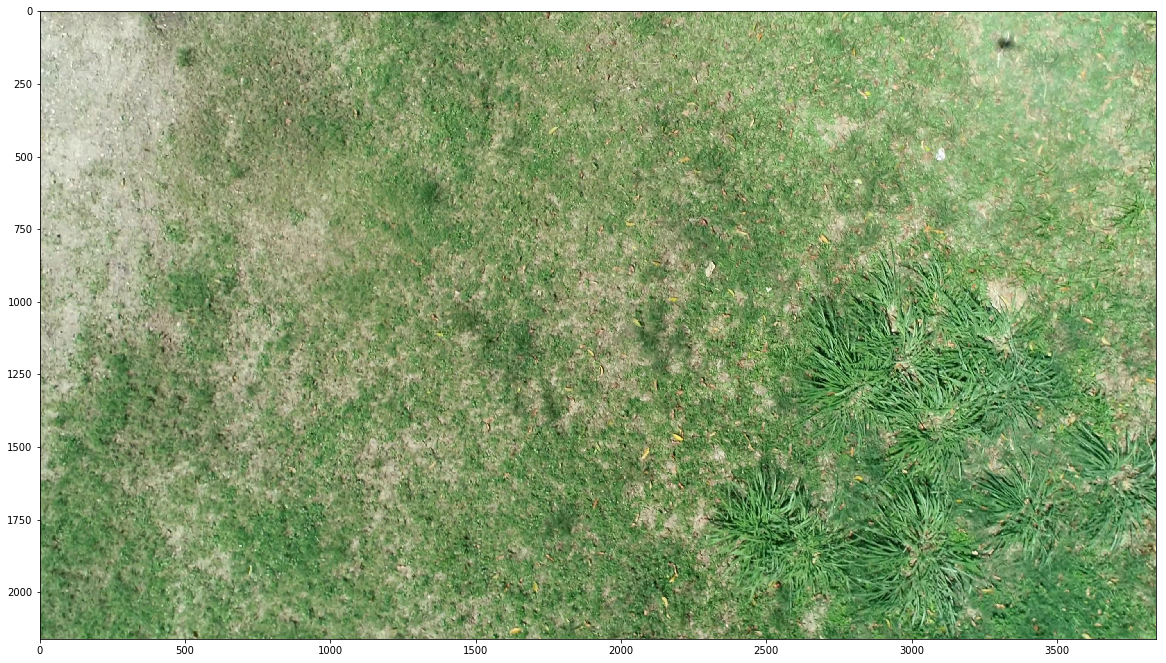

In [15]:
i = display_results_on_frame(vid, det[list_of_videos[0]], 1297)

## Phase correlation

In [16]:
from codes.utils.img_utils import add_bboxes_on_image, phase_correlation
from skimage.feature import register_translation

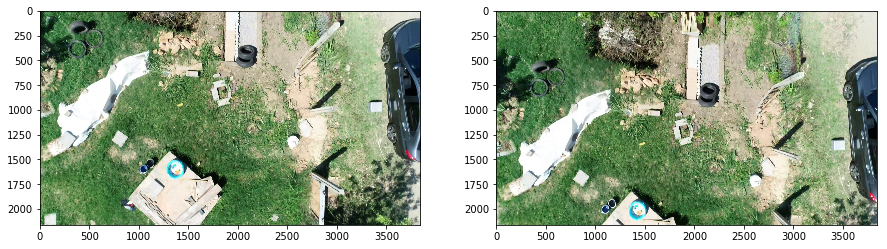

In [17]:
_, fa, _ = vid.get_frame(1080)
_, fb, _ = vid.get_frame(1085)


plt.figure(figsize=(15,9))

plt.subplot(1,2,1)
plt.imshow(fa[:,:,::-1])

plt.subplot(1,2,2)
plt.imshow(fb[:,:,::-1])

plt.show()

In [18]:
# my function
scale = 1
# %timeit phase_correlation(fa, fb, scale)
my_shift = phase_correlation(fa, fb, scale=scale)
print(my_shift)

((60.795249792653976, 389.0181337260318), 0.11165943004466869)


In [19]:
# using sklearn
# %timeit register_translation(fa, fb)
shift, error, diffphase = register_translation(fa, fb)
print(shift, error, diffphase)

[-389.  -60.    0.] 0.34522596058501287 2.845101144521564e-18


Of course, the sklearn function is much more general than mine.
But for our application, we can be more restrict and gain time.

In [20]:
fa_ = np.float32(cv2.cvtColor(fa, cv2.COLOR_BGR2GRAY))
fb_ = np.float32(cv2.cvtColor(fb, cv2.COLOR_BGR2GRAY))

# %timeit cv2.phaseCorrelate(fa_, fb_)
(x,y), c = cv2.phaseCorrelate(fb_, fa_) 

In [21]:
def video_phaseCorrelation(frame_generator):
    
    prev_frame = next(frame_gen)
    prev_frame = np.float32(cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY))
    
    
    corr = dict()
    (x,y), c = cv2.phaseCorrelate(prev_frame, prev_frame)            
    corr[0] = [x,y,c]
    
    for idx, frame in enumerate(tqdm(frame_generator)): 
        frame = np.float32(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))
        (x,y), c = cv2.phaseCorrelate(prev_frame, frame)        
        corr[idx + 1] = [x,y,c]
        prev_frame = frame
        
    return corr    

In [22]:
vid = videoObj(video_path,
              video_path.replace(".avi", ".txt"))
frame_gen = vid.frame_from_video()

phase_corr = video_phaseCorrelation(frame_gen)

In [23]:
import pandas as pd

In [24]:
df = pd.DataFrame(phase_corr).T
df.columns = ['x', 'y', 'corr']
df.head()

x             y      corr
0 -4.547474e-13 -4.547474e-13  0.999996
1  2.534614e+00 -1.729521e+00  1.054988
2  2.408315e+00 -1.629812e+00  1.087518
3  2.445661e+00 -1.565539e+00  1.082132
4  2.596850e+00 -1.332152e+00  1.025415

In [25]:
def get_pred_boxes_frame(idx):
    instances = det[list_of_videos[0]][f'frame_{idx:04d}']['instances'] 
    
    return instances.get('pred_boxes').to(device='cpu')

In [26]:
def shift_boxes(boxes, shift):        
    boxes_shifted = boxes.clone()    
    
    boxes_shifted.tensor[:, 0::2] += shift[0]    
    boxes_shifted.tensor[:, 1::2] += shift[1]
    
    return boxes_shifted    

In [27]:
def get_shift(df_shift, frame_from, n_frames):    
    desloc = df_shift.loc[min(frame_from, frame_from + n_frames) + 1 : max(frame_from, frame_from + n_frames)]
               
    total_shift_x = desloc.sum()['x']
    total_shift_y = desloc.sum()['y']

    if n_frames < 0:        
        total_shift_x *= -1
        total_shift_y *= -1
        
    return total_shift_x, total_shift_y    

In [28]:
def shift_all_frame_bboxes(df_shift, frame_from, n_frames, max_box_size=(2160, 3840)):
    
    bbs_pred = get_pred_boxes_frame(frame_from)    
    total_shift = get_shift(df_shift, frame_from, n_frames)          

    # offset the bboxes
    bbs_pred_offset = shift_boxes(bbs_pred, total_shift)

    # clamp the boxes with images limits    
    bbs_pred_offset.clip(max_box_size)
    
    return bbs_pred_offset

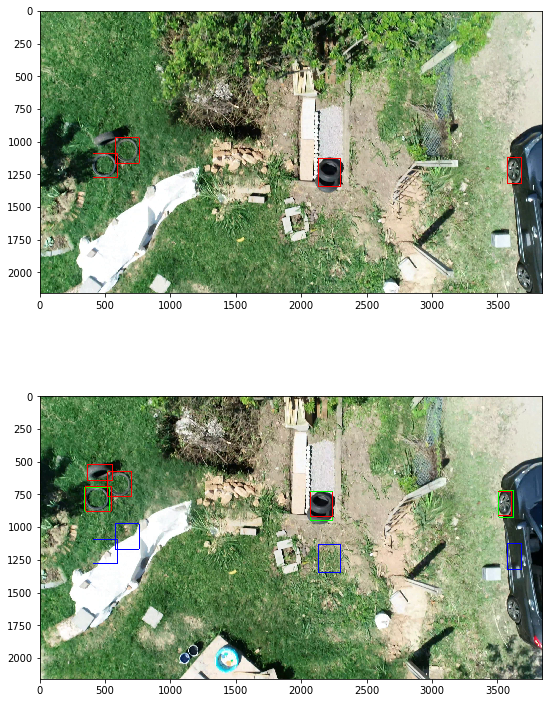

In [29]:
idx = 1090
step = -5
_, f1, _ = vid.get_frame(idx)
_, f2, _ = vid.get_frame(idx + step)

bbs_pred = get_pred_boxes_frame(idx)

f1 = add_bboxes_on_image(f1, bbs_pred, color=(255,0,0))
f2 = add_bboxes_on_image(f2, bbs_pred, color=(0,0,255))

bbs_prev_pCorr = shift_all_frame_bboxes(df, idx, step, f2.shape[:2])
bbs_pred_offset = get_pred_boxes_frame(idx+step)

# plot offset bboxes on offset image    
f2 = add_bboxes_on_image(f2, bbs_prev_pCorr, color=(0,255,0))
f2 = add_bboxes_on_image(f2, bbs_pred_offset, color=(255,0,0))

plt.figure(figsize=(9,13))
plt.subplot(2,1,1)
plt.imshow(f1[:,:,::-1])

plt.subplot(2,1,2)
plt.imshow(f2[:,:,::-1])

plt.show()

## criar boxes de um "pseudo-frame"

Este "pseudo frame" será usado como comparação para todos os outros frames dentro da janela.
Nele, são projetadas as boxes presentes na janela temporal, corrigindo o offset.

In [30]:
def concat_boxes(boxes1, boxes2):    
    list_boxes = [boxes1, boxes2]
    return Boxes(torch.cat([box.tensor for box in list_boxes], dim=0))

In [31]:
def get_missing_boxes(boxes_current, boxes_offset, shift, thr=0.5):
        
    # reprojeto as caixas do frame offset no frame de ref    
    boxes_offset_ = shift_boxes(boxes_offset, shift)
    
    # verifico se todas as boxes do frame deslocado estão no frame atual
    overlaps = pairwise_iou(boxes_offset_, boxes_current)
    pred_ovr, pred_ind = overlaps.max(dim=1)
    
    boxes_missing = boxes_offset_[pred_ovr < thr]
    
    return boxes_missing

In [32]:
def get_frames_to_see(frame_ref, window_size, center=False):
    if center:
        return np.arange(frame_ref - window_size//2, frame_ref + window_size//2 + 1)
    # causal window
    return np.arange(frame_ref - window_size + 1, frame_ref + 1)
    

In [33]:
def get_boxes_to_compare(frame_ref, df_shift, window_size=5, thr=0.5, center=False):    
    assert isinstance(window_size, int)
    
    frames_to_see = get_frames_to_see(frame_ref, window_size, center=center)        
        
    bbs_pred = get_pred_boxes_frame(frame_ref)
    boxes_to_compare = bbs_pred.clone()
        
    for frame_idx in frames_to_see:
        offset = frame_idx - frame_ref        
        if offset == 0:
            continue            
            
        bbs_pred_offset = get_pred_boxes_frame(frame_ref + offset)
        
        shift = get_shift(df_shift, frame_ref+offset, -offset)
        missing_boxes = get_missing_boxes(boxes_to_compare, bbs_pred_offset, shift, thr)                
        boxes_to_compare  = concat_boxes(boxes_to_compare, missing_boxes)
    
    return boxes_to_compare    

In [34]:
def get_frame_and_boxes(idx):
    _, frame, _ = vid.get_frame(idx)
    bbs_pred = get_pred_boxes_frame(idx)
    frame = add_bboxes_on_image(frame, bbs_pred, color=(255,0,0))
    return frame

In [35]:
def compare_boxes(bbs_current, bbs_to_compare, thr=0.5):
    overlaps = pairwise_iou(bbs_current, bbs_to_compare)
    gt_overlaps = torch.zeros(len(bbs_to_compare))
    
    for j in range(min(len(bbs_to_compare), len(bbs_current))):
            max_overlaps, argmax_overlaps = overlaps.max(dim=0)

            # find which gt box is 'best' covered (i.e. 'best' = most iou)
            gt_ovr, gt_ind = max_overlaps.max(dim=0)
            assert gt_ovr >= 0

            # find the proposal box that covers the best covered gt box
            box_ind = argmax_overlaps[gt_ind]

            # record the iou coverage of this gt box
            gt_overlaps[gt_ind] = overlaps[box_ind, gt_ind]
            assert gt_overlaps[gt_ind] == gt_ovr

            # mark the proposal box and the gt box as used
            overlaps[box_ind, :] = -1
            overlaps[:, gt_ind] = -1
            
    return (gt_overlaps >= thr).int()

def get_majority(votes, axis=0):    
    sum_votes = votes.sum(axis=axis)
    final_votes = sum_votes > votes.shape[axis]/2
    
    return final_votes.int()    

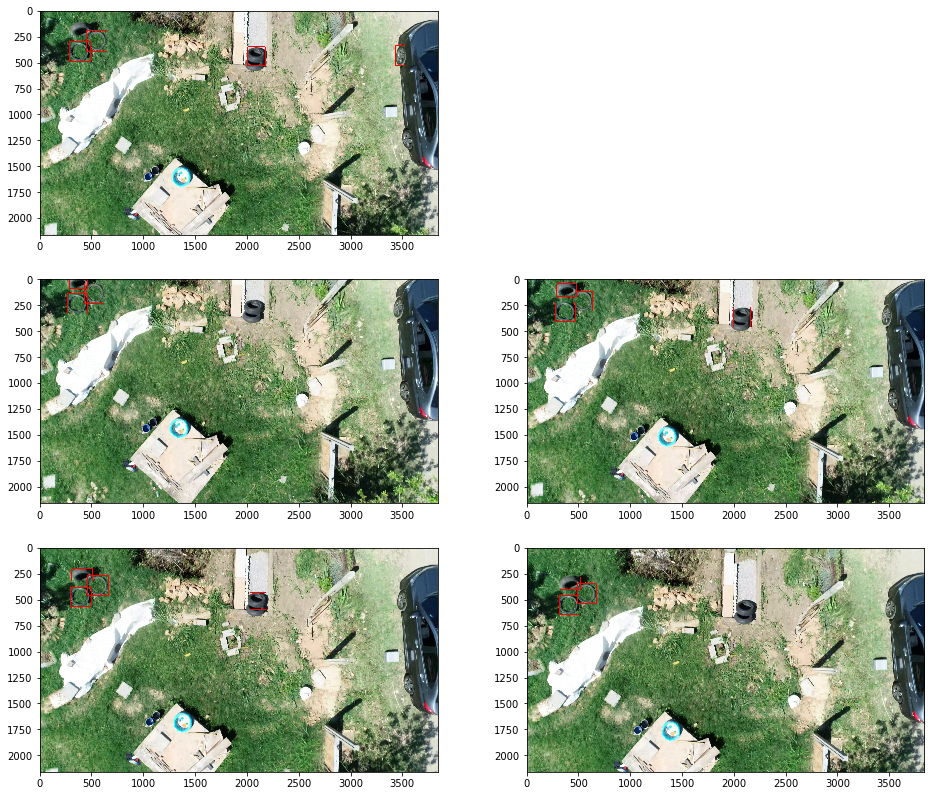

In [36]:
idx = 1080

plt.figure(figsize=(16,14))
plt.subplot(3,2,1)
f = get_frame_and_boxes(idx)
plt.imshow(f[:,:,::-1])

plt.subplot(3,2,3)
f = get_frame_and_boxes(idx-2)
plt.imshow(f[:,:,::-1])

plt.subplot(3,2,4)
f = get_frame_and_boxes(idx-1)
plt.imshow(f[:,:,::-1])

plt.subplot(3,2,5)
f = get_frame_and_boxes(idx+1)
plt.imshow(f[:,:,::-1])

plt.subplot(3,2,6)
f = get_frame_and_boxes(idx+2)
plt.imshow(f[:,:,::-1])

plt.show()

In [37]:
frame_ref = 1080
win_size = 5
center = True
thr = 0.5

all_candidates = get_boxes_to_compare(frame_ref, df, window_size=win_size, thr=thr, center=center)

votes = torch.zeros((win_size, len(all_candidates) ))

frames_to_see = get_frames_to_see(frame_ref, win_size, center=center)

for idx, frame_idx in enumerate(frames_to_see):
    current_boxes = get_pred_boxes_frame(frame_idx)    
    
    offset = frame_idx - frame_ref    
    shift = get_shift(df, frame_ref, offset)
    
    candidates_offset = shift_boxes(all_candidates, shift)
        
    frame_votes = compare_boxes(current_boxes, candidates_offset, thr=0.5) 
        
    if offset == 0:
        votes_current_frame = frame_votes

    votes[idx, :] = frame_votes    

final_votes = get_majority(votes)

print(votes_current_frame)
print(votes)
print(final_votes)

tensor([1, 1, 1, 1, 0], dtype=torch.int32)
tensor([[1., 1., 0., 0., 1.],
        [1., 1., 0., 1., 1.],
        [1., 1., 1., 1., 0.],
        [1., 1., 0., 1., 1.],
        [1., 1., 0., 0., 1.]])
tensor([1, 1, 0, 1, 1], dtype=torch.int32)


In [48]:
all_candidates

Boxes(tensor([[ 283.4897,  297.0231,  490.7470,  488.3527],
        [ 449.5369,  187.3322,  645.5742,  391.8858],
        [3429.8413,  334.4674, 3521.2986,  526.1356],
        [2005.5526,  345.1562, 2172.0959,  527.3820],
        [ 307.9626,  151.4462,  483.3345,  241.2413]]))

In [65]:
final_votes.nonzero().flatten()

tensor([0, 1, 3, 4])

In [66]:
all_candidates[final_votes.nonzero().flatten(), :]

Boxes(tensor([[ 283.4897,  297.0231,  490.7470,  488.3527],
        [ 449.5369,  187.3322,  645.5742,  391.8858],
        [2005.5526,  345.1562, 2172.0959,  527.3820],
        [ 307.9626,  151.4462,  483.3345,  241.2413]]))

In [38]:
import json

In [39]:
with open("../output/faster_rcnn_R_50_C4_1x/coco_instances_results.json") as json_file:
    data = json.load(json_file)

In [40]:
sorted_conf = sorted(data, key = lambda i: i['score'],reverse=True)

In [41]:
thr = 0.5
gt_overlaps, (gt_overlaps >= thr).int()

NameError: name 'gt_overlaps' is not defined

In [ ]:
sorted_conf

In [ ]:
data